In [1]:
# import packages
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import warnings
warnings.filterwarnings('ignore')

## PyTorch

PyTorch is an open-source machine learning library. It is one of the most popular frameworks for deep learning.

In Python, the PyTorch package is called `torch`, available [here](https://pytorch.org).


## Simple Linear Regression

Let's see how PyTorch can help us solve a predictive problem using the most **simple linear regression model**. 

A **simple linear regression model** assumes that the observed data sample $y_1, y_2, ..., y_n$ follows the following structure:

$$
y_i = a + bx_i + \epsilon_i, \quad \epsilon_i \sim N(0,1).
$$

### Data Generation

Let's start by creating some synthetic data to work with. The following code block does the following:

1. We generate $x_1, x_2, ..., x_{100}$ with each $x_i \sim \text{Uniform}(-2,2)$. 
2. We let $a = 1$ and $b = 2$.
3. We create $y_1, y_2, ..., y_{100}$ by setting $y_i = 1 + 2x_i + \epsilon_i$, where $\epsilon_i$ is some standard Gaussian noise.


In [47]:
# Data Generation
# np.random.uniform generates random samples from a uniform distribution over [0, 1).
x = np.random.uniform(low=-2,high=2, size =(100, 1))                              
# the resulting dimension of vector x will be 100 x 1.

# np.random.randn generates random samples from a standard normal distribution.
y = 1 + 2 * x + np.random.randn(100, 1)            

### Train-Validation Split

Now we do a train-validation split, by randomly picking 80% of the indices as the train set and the rest as validation.


In [48]:
# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

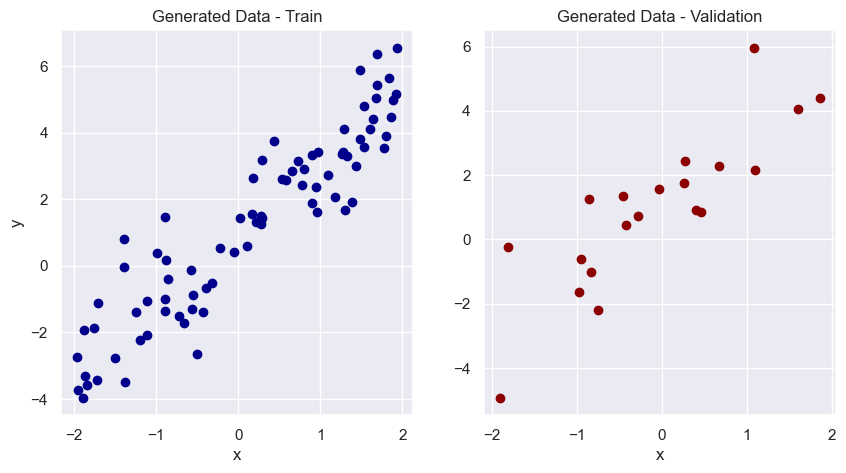

In [49]:
## Below shows a plot of the two sets of data.

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].scatter(x_train, y_train, c = 'darkblue')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Generated Data - Train')
axes[1].scatter(x_val, y_val, c = 'darkred')
axes[1].set_xlabel('x')
axes[1].set_title('Generated Data - Validation')
plt.show()

### Moving to PyTorch

Let's fit a linear regression model using PyTorch.

First, we need to transform our data to PyTorch tensors.

In [50]:
# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float)      
y_train_tensor = torch.tensor(y_train, dtype=torch.float)

In [51]:
# Here we can see the difference 
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


#### Initialize Parameters and Require Gradients

In [52]:
# Since we want to apply gradient descent on these parameters, we need
# to set requires_grad = True

### Initialize parameters... 
a = torch.randn(1, requires_grad=True)      
b = torch.randn(1, requires_grad=True)
### ---------------------- 

print(a, b)

tensor([0.0764], requires_grad=True) tensor([1.3134], requires_grad=True)


#### Gradient Computation with **Autograd**

The loss is:

$$ L(a, b) = \frac{1}{n} \sum_{i=1}^n (y_i - a- b\cdot x_i)^2 $$

The gradients are: 

$$ \frac{\partial L}{\partial a} = -2 \cdot \frac{1}{n} \sum_{i=1}^n (y_i - a - b\cdot x_i)$$
$$ \frac{\partial L}{\partial b} = -2 \cdot \frac{1}{n} \sum_{i=1}^n x_i(y_i - a - b\cdot x_i)$$

We won't actually have to compute gradients - autograd is PyTorch's automatic differentiation package, which will do it for us.

- The `backward()` method helps us to compute partial derivatives of the loss function w.r.t. our parameters. It is essentially saying "do backpropagation".
- We obtain the computed gradients via the `.grad` attribute.

In [53]:
# Specifying a learning rate
lr = 1e-1

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

# We just tell PyTorch to work its way BACKWARDS from the specified loss!
loss.backward()
# Let's check the computed gradients...
print('a grad (pytorch)', a.grad)
print('b grad (pytorch)', b.grad)

# compare to actual gradients
with torch.no_grad():
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train_tensor * error).mean()
print('a grad (manual)', a_grad)
print('b grad (manual)', b_grad)

a grad (pytorch) tensor([-1.9982])
b grad (pytorch) tensor([-2.5759])
a grad (manual) tensor(-1.9982)
b grad (manual) tensor(-2.5759)


Note: we use `torch.no_grad()` so PyTorch doesn't keep track of the operations (otherwise, they may be included in the computation graph that PyTorch uses to calculate gradients).

Let's now take a gradient descent step.

In [54]:
# update the parameters 
with torch.no_grad():       
    a -= lr * a.grad
    b -= lr * b.grad
# ---------------------- 

# PyTorch is "clingy" to its computed gradients, we need to tell it to zero out
a.grad.zero_()      # note the "_" which means "in-place"
b.grad.zero_()

tensor([0.])

Putting it all together:

In [55]:
n_epochs = 100

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()

    ### We just tell PyTorch to work its way BACKWARDS from the specified loss! 
    loss.backward()            
    ### ---------------------- 

    # Let's check the computed gradients...
    if epoch % 5 == 0:
        print('Epoch:', epoch, '(a, b) grad', a.grad, b.grad)
    
    # Updating the parameters
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    a.grad.zero_()
    b.grad.zero_()
    ### ---------------------- 
    
print('Final (a, b)', a, b)

Epoch: 0 (a, b) grad tensor([-1.5175]) tensor([-1.7315])
Epoch: 5 (a, b) grad tensor([-0.4175]) tensor([-0.2149])
Epoch: 10 (a, b) grad tensor([-0.1279]) tensor([-0.0152])
Epoch: 15 (a, b) grad tensor([-0.0417]) tensor([0.0038])
Epoch: 20 (a, b) grad tensor([-0.0141]) tensor([0.0027])
Epoch: 25 (a, b) grad tensor([-0.0048]) tensor([0.0012])
Epoch: 30 (a, b) grad tensor([-0.0017]) tensor([0.0004])
Epoch: 35 (a, b) grad tensor([-0.0006]) tensor([0.0002])
Epoch: 40 (a, b) grad tensor([-0.0002]) tensor([5.5239e-05])
Epoch: 45 (a, b) grad tensor([-6.8247e-05]) tensor([1.9357e-05])
Epoch: 50 (a, b) grad tensor([-2.3618e-05]) tensor([6.4149e-06])
Epoch: 55 (a, b) grad tensor([-8.0764e-06]) tensor([2.4475e-06])
Epoch: 60 (a, b) grad tensor([-2.6971e-06]) tensor([1.3188e-06])
Epoch: 65 (a, b) grad tensor([-8.7917e-07]) tensor([8.7172e-07])
Epoch: 70 (a, b) grad tensor([-3.4273e-07]) tensor([7.8976e-07])
Epoch: 75 (a, b) grad tensor([-1.7881e-07]) tensor([9.4995e-07])
Epoch: 80 (a, b) grad tenso

This is the same as the simple linear regression formula:

In [56]:
b_hat = ((x_train-x_train.mean()) * (y_train-y_train.mean())).sum() / ((x_train-x_train.mean())**2).sum()

In [58]:
a_hat = y_train.mean() - b_hat * x_train.mean()

In [ ]:
print(f"a (formula): {a_hat:.4f}, b (formula): {b_hat:.4f}")

a (ls): 0.9563, b (ls): 2.0711


#### Update All Parameters Simultaneously with **Optimizer**

Previously, we’ve been manually updating the parameters using the computed gradients. That’s probably fine for two parameters… but what if we had a whole lot of them?! We use one of PyTorch’s optimizers, like SGD or Adam.

An optimizer takes the parameters we want to update, the learning rate we want to use (and possibly many other hyper-parameters as well!) and performs the updates through its `step()` method.

Besides, we also don’t need to zero the gradients one by one anymore. We just invoke the optimizer’s `zero_grad()` method and that’s it!

In the code below, we create a Stochastic Gradient Descent (SGD) optimizer to update our parameters `a` and `b`. Note: we will use the whole dataset, not batches, so it is technically GD (not SGD). However, the optimizer in `torch` is still called `SGD`.

In [11]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
print(f"Initializations: a = {a.item():.3f}, b = {b.item():.3f}")

lr = 1e-1
n_epochs = 1000

### Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)
### ---------------------- 

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad

    ### perform the update via step() ###
    optimizer.step()
    ### ---------------------- ###
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()

    ### clearing the gradient ###
    optimizer.zero_grad()
    ### ---------------------- ###

print(f"Output: a = {a.item():.3f}, b = {b.item():.3f}")

Initializations: a = -0.684, b = 0.537
Output: a = 1.113, b = 1.973


### Model Building 

Python is an **object-oriented programming** language.

Every item you interact with is an object. An object has a type, as well as:

- attributes (values)
- methods (functions that can be applied to the object)

As an example, `'hello'` in Python is an object of type `str`, with methods such as `split`, `join` etc.

A Python class is a "blueprint" for an object. 

Inheritance allows us to define a class that inherits all the methods and properties from another class.

#### `nn.Module` Class

In PyTorch, a model is represented by a regular Python class that inherits from the `nn.Module` class. `nn.Module` is everywhere in PyTorch and represents mappings in neural networks. 

Let's look at an example:

In [12]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()              # inherits from nn.Module
        # Initialization of a and b.
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x


- `class ManualLinearRegression(nn.Module)`

    - this statement declares a class `ManualLinearRegression` which inherits from the base class `nn.Module`.


Indented beneath the class statement are the methods of this class: `__init__` and `forward`:

- `__init__`

    - all classes have an `__init__` which is executed when the class is instantiated
    - `self` refers to an instance of the class
    - in `__init__`, we have attached the parameters `a` and `b` as attributes
    - `super().__init__()` is a call to the `__init__` of `nn.Module`. For torch models, we will always be making this `super()` call as it is necessary for the model to be properly interpreted by torch.

- `forward` is called when the neural network is run on input data.


In [13]:
# Now we can create a model 
model = ManualLinearRegression()
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # In PyTorch, models have a train() method which sets the model to training mode.
    
    ### enter training mode 
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor

    ### this is the forward step 
    yhat = model(x_train_tensor)
    ### ---------------------- 
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict({'a': tensor([-0.6481]), 'b': tensor([1.4267])})
OrderedDict({'a': tensor([1.1129]), 'b': tensor([1.9731])})


#### Utilizing PyTorch Layers

For simple tasks like building a linear regression, we could directly create `a` and `b` as `nn.Parameters`. 

Instead, we can use PyTorch's `nn.Linear` to create a linear layer. Later, this will let us build more complicated networks. Note: `nn.Linear` automatically adds a bias term.

In [14]:
class PyTorchLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1) # arguments: (input dim, output dim)
                
    def forward(self, x):
        return self.linear(x)


In [15]:
for name, param in PyTorchLinearRegression().named_parameters():
    if param.requires_grad:
        print(name, param.data)

linear.weight tensor([[-0.5715]])
linear.bias tensor([-0.5772])


In [16]:
# Now we can create a model 
model = PyTorchLinearRegression()
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # In PyTorch, models have a train() method which sets the model to training mode.
    
    ### enter training mode ###
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor

    ### this is the forward step ###
    yhat = model(x_train_tensor)
    ### ---------------------- ###
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict({'linear.weight': tensor([[-0.0886]]), 'linear.bias': tensor([0.0320])})
OrderedDict({'linear.weight': tensor([[1.9731]]), 'linear.bias': tensor([1.1129])})


## XOR problem

The "XOR" (or "exclusive OR") problem is often used to illustrate the ability of neural networks to fit complicated functions. The XOR problem has a checkerboard structure:

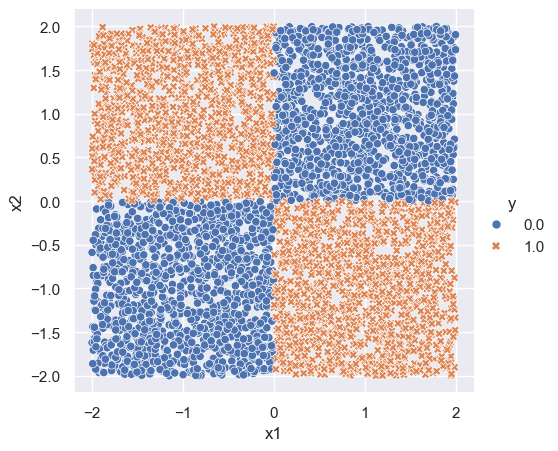

In [17]:
n = 5000
p = 2
x = np.random.uniform(-2, 2, size=(n, p))

#x[,1] <- first column (R)
#x[:, 0] <- first column (Python)

y = ((x[:,0] < 0) & (x[:, 1] > 0)).astype(x.dtype) + ((x[:,0] > 0) & (x[:, 1] < 0)).astype(x.dtype)

df = np.hstack([y.reshape((n, 1)), x])
df = pd.DataFrame(df, columns = ['y', 'x1', 'x2'])

sns.set_theme()
xor_plot = sns.relplot(df, x='x1', y='x2', hue='y', style='y')
xor_plot.figure.subplots_adjust(top=.9)

Logistic regression can only fit linear decision boundaries, and so fails the XOR problem.

(-2.0, 2.0)

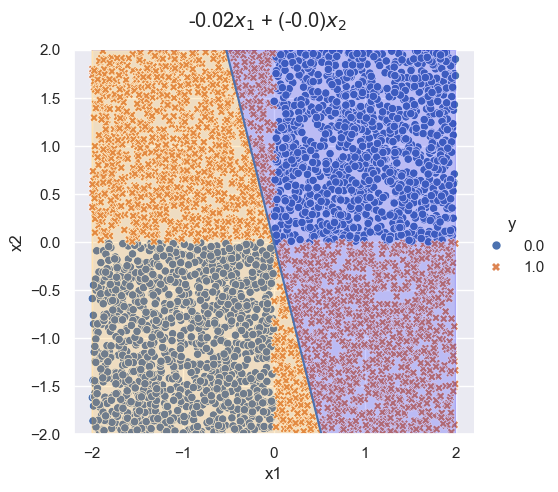

In [18]:
## logitstic regression doesn't work
log_fit = LogisticRegression()
log_fit.fit(x, y)
coeffs = log_fit.coef_[0]
coeff = -coeffs[0]/coeffs[1]

## plot
logit_plot = sns.relplot(df, x='x1', y='x2', hue='y', style='y')
plt.axline([0,0], slope=coeff)
## title
logit_plot.figure.subplots_adjust(top=.9)
logit_plot.figure.suptitle(str(round(coeffs[0], 2)) + r'$x_1$ + ' + '(' + str(round(coeffs[1], 2)) + ')' + r'$x_2$')
## fill in area
x_fill = np.linspace(-2, 2, num=200)
y_line = coeff * x_fill
logit_plot.ax.fill_between(x_fill, y_line, 2, color='blue', alpha=0.2)
logit_plot.ax.fill_between(x_fill, -2, y_line, color='orange', alpha=0.2)
logit_plot.ax.set_ylim(-2,2)

### Multi-Layer Neural Network

Here is an example of a one hidden-layer neural network in `torch` named `XORNet`.

Instead of a single linear layer, we have:

- a linear layer
- a ReLU activation
- a linear layer
- a sigmoid activation

`nn.Sequential` allows us to stack these layers together - we store the final object as an attribute of the model: `self.sequential`.

The `forward` method then passes input data through `self.sequential` to get the output. That is:

$$ f(x_i) = g(W^{(2)}(a(W^{(1)}x_i + b^{(1)}))+b^{(2)})$$

In [19]:
class XORNet(nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())

    def forward(self, x):
        y = self.sequential(x)
        y = torch.flatten(y) # we do this to turn y into a one-dim tensor
        return y

    def loss_fn(self, y, y_pred):
        loss = y * torch.log(y_pred + 1e-8) + (1-y) * torch.log(1-y_pred + 1e-8)
        output = -loss.sum()
        return output

In [20]:
hidden_dim=2
model = XORNet(input_dim=p, hidden_dim=hidden_dim)

In [21]:
model

XORNet(
  (sequential): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

### Data
For torch to read the data, it needs to be a `torch.tensor` type:

In [22]:
x_train = torch.tensor(x, dtype=torch.float)
y_train = torch.tensor(y, dtype=torch.float)

We combine `x_train` and `y_train` into a `TensorDataset`, a dataset recognizable by torch. `TensorDataset` stores the samples and their labels. It is a subclass of the more general `torch.utils.data.Dataset`, which you can customize for non-standard data.

In [23]:
train_data = TensorDataset(x_train, y_train)

`TensorDataset` is helpful as it can be passed to `DataLoader()`. `DataLoader` wraps an iterable around the `Dataset` class. This lets us loop over the DataLoader to extract a mini-batch at each iteration. 


In [24]:
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)

To retrieve a sample mini-batch, the following will return a list containing two tensors: one for the features, another one for the labels.

In [25]:
next(iter(train_loader))

[tensor([[-1.0248, -0.2131],
         [-0.7861,  1.6893],
         [-1.7932, -0.0574],
         [ 0.7178, -0.4897],
         [ 1.9000,  1.6038],
         [ 0.7674, -1.9498],
         [-0.2336, -1.4478],
         [-1.9838, -0.8512],
         [-0.2094,  0.1471],
         [-1.2884, -0.1538]]),
 tensor([0., 1., 0., 1., 0., 1., 0., 0., 1., 0.])]

### Training
We now set up the optimizer for training. We use Adam, and a base learning rate of `lr=0.01`. We set the number of epochs to 100. (Rule of thumb: pick largest `lr` that still results in convergence)

In [26]:
lr = 0.01
epochs = 100

optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

XORNet(
  (sequential): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

Now we train the model:

In [27]:
for epoch in range(epochs):
    
    # in each epoch, iterate over all batches of data (easily accessed through train_loader)
    l = 0

    for x_batch, y_batch in train_loader:

        pred = model(x_batch)                   # this is the output from the forward function
        loss = model.loss_fn(y_batch, pred)     # calculate loss function

        loss.backward()                         # computes gradients wrt loss function
        optimizer.step()                        # updates parameters 
        optimizer.zero_grad()                   # set the gradients back to zero (otherwise grads are accumulated)

        l += loss.item()

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{l:.3}")


epoch:  0 loss: 2.55e+03
epoch:  10 loss: 1.79e+03
epoch:  20 loss: 1.79e+03
epoch:  30 loss: 1.79e+03
epoch:  40 loss: 1.79e+03
epoch:  50 loss: 1.79e+03
epoch:  60 loss: 1.79e+03
epoch:  70 loss: 1.79e+03
epoch:  80 loss: 1.79e+03
epoch:  90 loss: 1.78e+03


To visualize the end result, we plot the predicted values over the whole space (the decision surface).

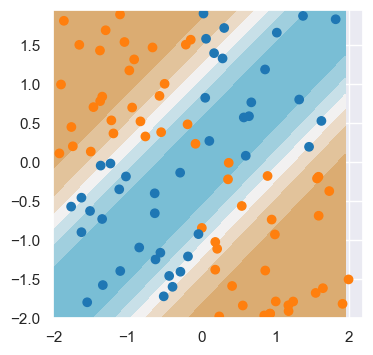

In [28]:
x1 = np.arange(-2, 2, 0.05)
x2 = np.arange(-2, 2, 0.05)

x_test_np = np.array([(i, j) for i in x1 for j in x2])
y_test_np = ((x_test_np[:,0] < 0) & (x_test_np[:, 1] > 0)).astype(x_test_np.dtype) + ((x_test_np[:,0] > 0) & (x_test_np[:, 1] < 0)).astype(x_test_np.dtype)

x_test = torch.tensor(x_test_np, dtype=torch.float)
y_test = torch.tensor(y_test_np)


model.eval()
y_pred = model(x_test)

y_pred_np = y_pred.detach().numpy()
y_pred_np = y_pred_np.reshape(x1.shape[0], x2.shape[0])

seaborn_cols = sns.color_palette("tab10")
cols = [seaborn_cols[int(i)] for i in y]

custom_cmap = sns.diverging_palette(220, 50, s=70, l=70, as_cmap=True)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.contourf(x1, x2, y_pred_np, cmap=custom_cmap)
ax.scatter(x[0:100,0], x[0:100,1], c=cols[0:100])

In [29]:
model.sequential[0].weight

Parameter containing:
tensor([[-2.3491,  2.3204],
        [ 2.4103, -2.3208]], requires_grad=True)

In [30]:
model.sequential[0].bias

Parameter containing:
tensor([-0.0632, -0.1064], requires_grad=True)

In [31]:
model.sequential[2].weight

Parameter containing:
tensor([[1.3308, 1.3007]], requires_grad=True)

In [32]:
model.sequential[2].bias

Parameter containing:
tensor([-3.4300], requires_grad=True)

Play around with different sizes of `hidden_dim` and see the difference!

## MNIST example

We use `torchvision.datasets` to download the MNIST data.

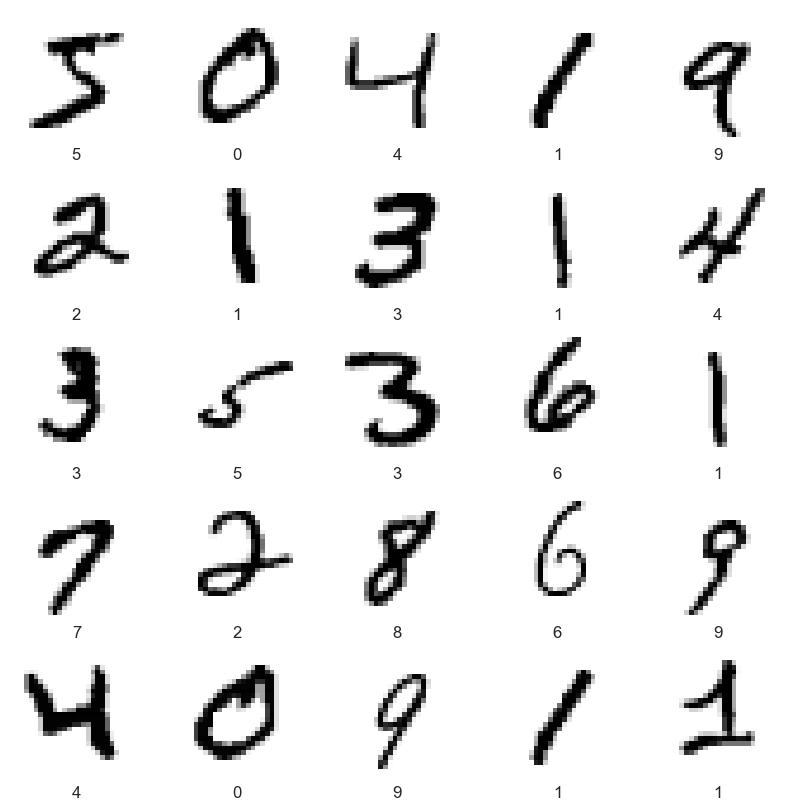

In [33]:
(mnist_train,
 mnist_test) = [torchvision.datasets.MNIST(root='data',
                      train=train,
                      download=True,
                      transform=torchvision.transforms.ToTensor())
                for train in [True, False]]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    train_image, label = mnist_train[i]
    plt.imshow(train_image[0], cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()

Set up our dataloaders.

In [34]:
train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=False)

Let's define our neural network for the MNIST classification problem.

In [35]:
class MNISTNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax()
        )

    def forward(self, x):
        prob = self.layers(x)
        return prob

    def loss_fn(self, y, y_pred):
        log_pred = torch.log(y_pred + 1e-8)
        loss = -(log_pred * y).sum(1).mean()
        return loss

Instantiate our model:

In [36]:
model = MNISTNet()

Train our model:

In [37]:
lr = 0.001
epochs = 50

optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

for epoch in range(epochs):
    l = 0
    for x_batch, y_batch in train_loader:

        x_batch = x_batch.reshape(x_batch.shape[0], 28*28)
        y_batch = F.one_hot(y_batch, num_classes=10)
        y_pred = model(x_batch)
        loss = model.loss_fn(y_batch, y_pred)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        l += loss.item()

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{l:.3}")

epoch:  0 loss: 2.59e+02
epoch:  10 loss: 13.7
epoch:  20 loss: 7.05
epoch:  30 loss: 7.11
epoch:  40 loss: 7.72


Calculate our accuracy:

In [38]:
model.eval()
x_batch, y_batch = next(iter(test_loader))
x_batch = x_batch.reshape(x_batch.shape[0], 28 * 28)
y_pred_array = model(x_batch)
y_pred = torch.argmax(y_pred_array, axis=1)
acc = (y_pred == y_batch).sum()
acc = acc / len(y_pred)

Let's look at some interesting results (code adapted from [here](https://github.com/probml/pyprobml/blob/master/notebooks/book1/13/mlp_mnist_tf.ipynb))

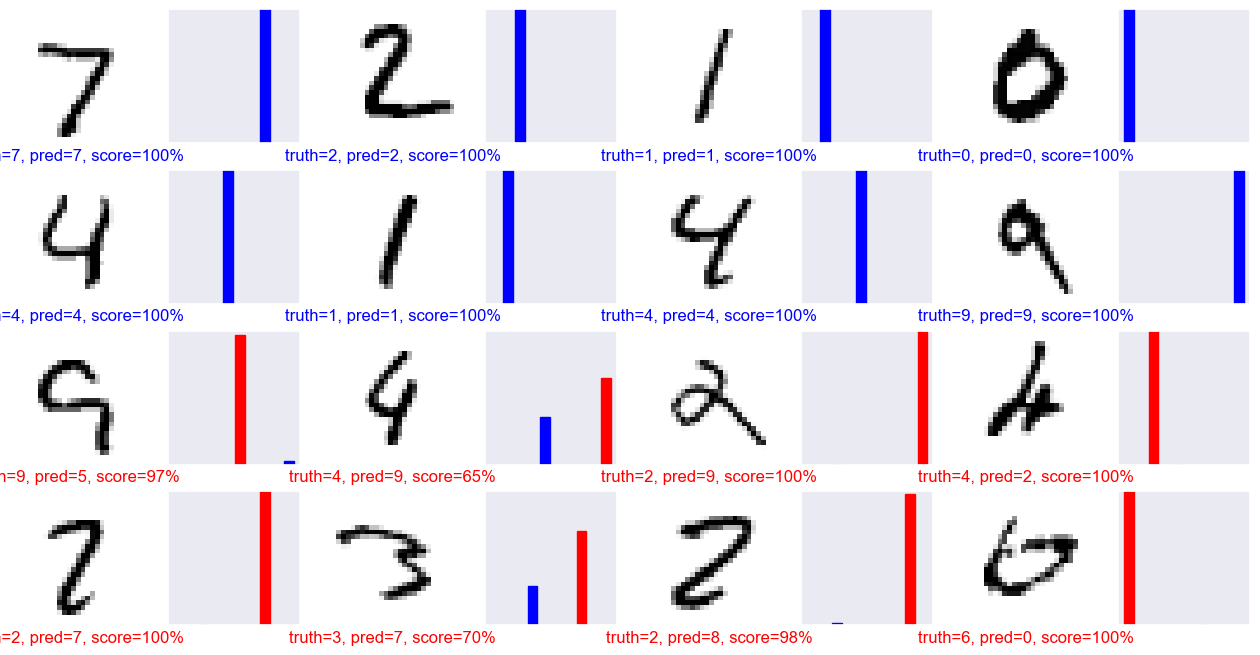

In [39]:
# find interesting test images
errors = torch.where(y_pred != y_batch)[0]
inds1 = range(8)
inds2 = errors[:8]
inds = np.concatenate((inds1, inds2))

pred_array = y_pred_array.detach().numpy()

num_rows = 4
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(num_images):
    n = inds[i]
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image, label = mnist_test[n]
    plt.imshow(image[0], cmap=plt.cm.binary)
    plt.xlabel(label)
    predicted_label = y_pred[n]
    if predicted_label == label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("truth={}, pred={}, score={:2.0f}%".format(
        label,
        predicted_label,
        100 * np.max(pred_array[n])),
        color=color)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), pred_array[n], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(pred_array[n])
    thisplot[predicted_label].set_color('red')
    thisplot[label].set_color('blue')

## Heteroskedastic regression

This code is adapted from [here](https://github.com/probml/pyprobml/blob/master/notebooks/book1/13/mlp_1d_regression_hetero_tfp.ipynb).

In [40]:
# Make data

x_range = [-20, 60]  # test
x_ranges = [[-20, 60]]
ns = [1000]

def load_dataset():
    def s(x):  # std of noise
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 0.25 + g**2.0

    x = []
    y = []
    for i in range(len(ns)):
        n = ns[i]
        xr = x_ranges[i]
        x1 = np.linspace(xr[0], xr[1], n)
        eps = np.random.randn(n) * s(x1)
        y1 = (1 * np.sin(0.2 * x1) + 0.1 * x1) + eps
        x = np.concatenate((x, x1))
        y = np.concatenate((y, y1))
    # print(x.shape)
    x = x[..., np.newaxis]
    n_test = 150
    x_test = np.linspace(*x_range, num=n_test).astype(np.float32)
    x_test = x_test[..., np.newaxis]
    return y, x, x_test

y, x, x_test = load_dataset()

Define neural network

In [41]:
class HetNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dims, mean_dims, var_dims):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dims
        self.mean_dims = mean_dims
        self.var_dims = var_dims

        # create backbone
        current_dim = input_dim
        self.layers = nn.ModuleList()
        for i in range(len(hidden_dims)):
            hdim = hidden_dims[i]
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim

        # create heads
        core_dim = hidden_dims[-1]
        current_dim = core_dim
        self.mean_layers = nn.ModuleList()
        for i in range(len(mean_dims)):
            hdim = mean_dims[i]
            self.mean_layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.mean_layers.append(nn.Linear(current_dim, output_dim))

        current_dim = core_dim
        self.var_layers = nn.ModuleList()
        for i in range(len(var_dims)):
            hdim = var_dims[i]
            self.var_layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.var_layers.append(nn.Linear(current_dim, output_dim))

    def core_net(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return x

    def mean_net(self, x):
        for layer in self.mean_layers[:-1]:
            x = F.relu(layer(x))
        x = self.mean_layers[-1](x)
        return x

    def var_net(self, x):
        for layer in self.var_layers[:-1]:
            x = F.relu(layer(x))
        x = self.var_layers[-1](x)
        return x

    def forward(self, x):
        mean = self.mean_net(self.core_net(x))
        log_var = self.var_net(self.core_net(x))

        return mean, log_var

    def loss_fn(self, x, y):
        mean, log_var = self.forward(x)
        var = torch.exp(log_var)

        loss = torch.pow(y-mean, 2) / var + log_var
        out = loss.mean()

        return out

Set up data

In [42]:
x_train = torch.tensor(x, dtype=torch.float)
y_train = torch.tensor(y, dtype=torch.float)
y_train = y_train.unsqueeze(-1)

train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)

Initialize model

In [43]:
hidden_dims = [50, 50]
mean_dims = [20]
var_dims = [20]
model = HetNet(input_dim=1, output_dim=1, hidden_dims=hidden_dims, mean_dims=mean_dims, var_dims=var_dims)

Train

In [44]:
lr = 0.001
epochs = 500

optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

for epoch in range(epochs):

    l = 0
    for x_batch, y_batch in train_loader:

        loss = model.loss_fn(x_batch, y_batch)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        l += loss.item()

    if epoch % 50 == 0:
        print('epoch: ', epoch, 'loss:', f"{l:.3}")

epoch:  0 loss: 1.27e+02
epoch:  50 loss: 2.11
epoch:  100 loss: -13.7
epoch:  150 loss: -23.8
epoch:  200 loss: -26.2
epoch:  250 loss: -26.0
epoch:  300 loss: -31.2
epoch:  350 loss: -31.0
epoch:  400 loss: -31.0
epoch:  450 loss: -29.0


Plot results

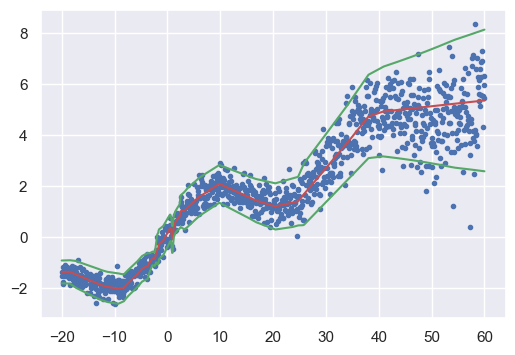

In [45]:
model.eval()
mean, log_var = model(x_train)
sd = torch.exp(0.5 * log_var)
mean_np = mean.detach().numpy()
sd_np = sd.detach().numpy()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 4)
ax.plot(x, y, '.', label="observed")
ax.plot(x, mean_np, 'r-')
ax.plot(x, mean_np + 2 * sd_np, 'g-')
ax.plot(x, mean_np - 2 * sd_np, 'g-')